# Spatio Temporal Logistic
This notebook is the first test of a spatio temporal logistic to link properly the **built-up surface** of a given region depending on its quality of life (**GDP/cap**) and of its **population density**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Region import Region
# import pandas as pd
import geopandas as gpd

from concurrent.futures import ThreadPoolExecutor
from termcolor import colored

In [2]:
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr


def RMSE(obs, pred):
    # root mean squared error
    return np.sqrt(mean_squared_error(obs, pred))

def MAPE(obs, pred):
    # Mean absolute percentage error
    return np.mean(np.abs((obs - pred) / obs)) * 100

def STDR(obs, pred):
    # Standard deviation of residuals
    residuals = obs - pred
    return np.std(residuals)

def BIAS(obs, pred):
    # Standard bias
    residuals = obs - pred
    return np.mean(residuals)

def PEARSON(obs, pred):
    r, p = pearsonr(obs, pred)
    return r, p

def R_SQ(y_obs, y_pred):
    # Calculate residual sum of squares (SS_res)
    ss_res = np.sum((y_obs - y_pred) ** 2)

    # Calculate total sum of squares (SS_tot)
    ss_tot = np.sum((y_obs - np.mean(y_obs)) ** 2)

    # Calculate R-squared
    return 1 - (ss_res / ss_tot)

In [3]:
def concordance_correlation_coefficient(y_true, y_pred):
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    cov = np.cov(y_true, y_pred)[0, 1]
    return (2 * cov) / (var_true + var_pred + (mean_true - mean_pred)**2)

## PART 1 : Theory
First we define some classical functions that will be used later for our modelisation.

### The logistic function
$f(t) = \frac{S}{1+e^{(-k(t-t_0))}}$

with: 
- *S* : the saturation level
- *k* : the slope
- $t_0$ : the half height value (left right alignement).

The logistic function serves as a predictive equation and as the motor of our dynamical models. Indeed, we observe that at the country scale, as time passes, the GDP/cap increases and some observables as the number of cars or as the number of m2/cap. This means that the quality of life, and thus the stocks consumed by a region improve. But this exponential growth does not increase indefinetely. A saturation is observed even if the GDP/cap still increase. This is explained because people usually do not own 2 or 3 cars even though they possess the money to. An logistic function, also known as the S curve, is a way to model this observation.

### The exponential decay function
$f(x) = a\, e^{-b\,x}$

with:
- *a* : the slope
- *b* : the half-life
- *c* : the bias.

The exponential decay is a decreasing exponential observed in nature (for example for the probability of nuclear decay over time). This is one of our assumption to model the decreasing phenomena observed betwenn the **built-up surface/cap** and the **population density** of a region.

In [4]:
def logistic(x, a, b, c):
    return a / (1 + np.exp(-b*(x-c)))

def exponential_decay_bias(X, a, b, c):
    return a * np.exp(-b * X) + c

def exponential_decay(X, a, b):
    return a * np.exp(-b * X) 

### The Spatio Temporal Logistic function
$f(t,x) = \frac{a\,e^{-b\,x}+c}{1 + e^{(-k(t-t_0))}}$

The Spatio Temporal Logistic function (**STL**) is the mix between our classical logistic expression and the exponential decay as S (the saturation level).

In [5]:
def STL(X, a, b, c, d, e):
    # STL stands for Spatio Temporal Logistic. It is an refinment of a logistic, dependant on time (here the grp_pc_usd_2015 serves 
    # as proxy for time), with a saturation level which is a function of space (here the population density of a region)
    x1, x2 = X
    saturation = exponential_decay_bias(x2, a, b, c)
    return saturation / (1 + np.exp(-d*(x1-e)))

## PART 2 : Initialisation
Initialisation of the analysis parameters.

- **region_names** : (*string*) the country to study, named by their ISO3 
- **years** : (*string*) years to study
- **raster_S** : (*string*) letter used in the **GHSL** dataset (S, S_NRES, POP, ...)
- **lvl** : (*int*) the level of our administrative data (GDP and population)
- **subregion_borders** : (*string*) the path to administrative border shapefile to cut the subregions 
- **i dentifier** : (*string*) the column name to match the region names between the administrative data and the GIS data

To each region is associated a **DataFrame** (*oecd_DF_merged*) with the subregions matching administrative observables (GDP, population, etc).

In [6]:
lvl = 1

# GHSL type
raster_str = "Built_V"

y_col = "Built up volume GHSL"
y_label_str = "Observed built-up volume (m^3) per capita"

In [7]:
max_workers = 16

In [8]:
data_folder = "/data/mineralogie/hautervo/data/"
folder_GHSL_S = data_folder + "Outputs/GHSL/" + raster_str + "/GADM_" + str(lvl) + "/"
folder_GHSL_POP = data_folder + "Outputs/GHSL/POP/GADM_" + str(lvl) + "/"
folder_DOSE = data_folder + "Outputs/DOSE/GADM_" + str(lvl) + "/"
folder_OSM_building = data_folder + "Outputs/OSM/building/GADM_" + str(lvl) + "/"

In [9]:
# The OECD admin units

# oecd_admin_units = data_folder + "OECD/admin_units/TL" + str(lvl) + "/OECD_TL" + str(lvl) + "_2020_ESRI54009.shp"
# gpd_oecd_admin_units = gpd.read_file(oecd_admin_units)

gadm_admin_units = data_folder + "GADM/ESRI_54009/GADM_" + str(lvl) + "_ESRI54009.shp"
gpd_gadm_admin_units = gpd.read_file(gadm_admin_units, ignore_geometry=True)

In [10]:

subregion_col = "GID_"+str(lvl)
parent_col = "GID_" + str(lvl-1) 

In [11]:
# Countries to ignore from our study (not enough data)
# country_to_pop = ["SRB", "CRI", "ISR", "CYP", "ISL", "ALB", "LIE","MNE","MKD"]
country_to_pop = ["ATA"]

In [141]:
regions_names = list(gpd_gadm_admin_units["GID_0"].unique())

# #exclude some countries if necessary
for c in country_to_pop:
    try:
        regions_names.pop(regions_names.index(c))
    except:
        pass

EU = ["FRA", "DEU", "GBR", "BEL", "ITA", "ESP"] 
NA = ["USA", "CAN"] 
OC = ["AUS"]
JP = ["JPN"]
AS = ["CHN", "IND", "IDN"]
REST = ["BRA", "RUS", "ZAF"]
WORLD = EU + NA + OC + JP + AS + REST

regions_names = ["FRA", "DEU", "GBR", "BEL", "ITA", "ESP", "CAN", "AUS", "JPN", "CHN"] # to remove
regions_names = ["FRA", "DEU", "GBR", "BEL", "ITA", "ESP", "USA", "CAN", "AUS", "JPN", "CHN", "IND", "IDN"] # to remove
regions_names = ["FRA", "DEU", "GBR", "BEL", "ITA", "ESP", "USA", "CAN", "AUS", "JPN", "CHN", "IND", "RUS", "BRA", "ZAF", "IDN"] # to remove
regions_names = WORLD
regions_names = ["FRA", "DEU"] #, "USA", "CAN", "AUS", "CHN", "IND"]
# regions_names = EU

years = ["1975", "1990", "2000", "2010", "2020"] 
# years = ["2000", "2010", "2020"]
# years = ["2010"]

regions = []

for name in regions_names:
    new_region = Region(name, lvl-1)
    regions.append(new_region)


In [142]:
def preprocess(region):
    region.make_subregions_visual(gpd_gadm_admin_units, subregion_col, parent_col, [folder_GHSL_S, folder_GHSL_POP, folder_DOSE], years)

In [143]:
with ThreadPoolExecutor(max_workers=max_workers) as executor:
        executor.map(preprocess, regions)

In [144]:
# the value for the plots

year_min = 1975
year_max = 2020
z_min = 0
z_max = 1000
x_min =  0
x_max = 50000
y_min = 0
y_max = 0.004

In [145]:
### To fit the logistic part, we combine all the regional data to get the national mean

df_gdp_cap_region_handler_log = []
df_pop_density_region_handler_log = []
df_built_up_region_handler_log = []

x_col1 = "grp_pc_usd_2015"
x_col2 = "Total surface"

pop_col = "pop"

for region in regions:
    df_pop_density_region = []
    df_gdp_cap_region = [0]
    df_built_up_region = [0]    

    for y in years:
        total_pop = 0
        total_built_up_surface = 0
        total_surface = 0
        total_gdp = 0
        for subregion in region.subregions:
            try:
                filtered_df = subregion.output_df_merged.dropna(subset=["year", x_col1, x_col2, pop_col, y_col])
                filtered_df = filtered_df[filtered_df["year"] == int(y)]
                total_gdp += (filtered_df[x_col1].values[0] * filtered_df[pop_col].values[0])
                total_built_up_surface += filtered_df[y_col].values[0]
                total_pop += filtered_df[pop_col].values[0]
                total_surface += filtered_df[x_col2].values[0]
            except Exception as e : 
                # print(e)
                pass

        if total_gdp != 0:
            df_gdp_cap_region.append(total_gdp/total_pop)
            df_built_up_region.append(total_built_up_surface/total_pop)
            df_pop_density_region.append(total_pop/total_surface)
        else:
            # df_gdp_cap_region.append(0)
            # df_built_up_region.append(0)
            print(colored(f"No data for {region.name} at {y}", "yellow"))
    
    # print(region.name, round(df_pop_density_region[-1], 5))

    if df_gdp_cap_region and df_built_up_region:
        df_gdp_cap_region_handler_log.append(df_gdp_cap_region)
        df_built_up_region_handler_log.append(df_built_up_region)
        df_pop_density_region_handler_log.append(df_pop_density_region)
    else:
       df_gdp_cap_region_handler_log.append([0, 0])
       df_built_up_region_handler_log.append([0, 0])
       print(region.name, " is  empty and won't be fitted")

In [146]:
# # Concatenate all the data points

df_gdp_cap_region_handler = []
df_pop_density_region_handler = []
df_built_up_region_handler = []

x_col1 = "grp_pc_usd_2015"
x_col2 = "Total surface"

pop_col = "pop"

for region in regions:
    df_gdp_cap_region = []
    df_pop_density_region = []
    df_built_up_region = []    

    for subregion in region.subregions:
        
        filtered_df = subregion.output_df_merged.dropna(subset=["year", x_col1, x_col2, pop_col, y_col])
        df_gdp_cap_region = df_gdp_cap_region + filtered_df[x_col1].to_list()
        df_pop_density_region = df_pop_density_region + (filtered_df[pop_col] / filtered_df[x_col2]).to_list()
        df_built_up_region = df_built_up_region + (filtered_df[y_col] / filtered_df[pop_col]).to_list()      

    if df_gdp_cap_region and df_pop_density_region and df_built_up_region:
        df_gdp_cap_region_handler.append(df_gdp_cap_region)
        df_pop_density_region_handler.append(df_pop_density_region)
        df_built_up_region_handler.append(df_built_up_region)
    else:
       df_gdp_cap_region_handler.append([0, 0])
       df_pop_density_region_handler.append([0, 0])
       df_built_up_region_handler.append([0, 0])
       print(region.name, " is  empty and won't be fitted")

## PART 3 : First analysis and plots
Here we can, if we want or need to, filter some subregions from our study. 

Thus, we can plot our observables.

In [147]:
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('xx-small')

colors_reg = [
    "black", "red", "peru", "darkorange", "gold", "purple", "magenta", "chartreuse", "turquoise", "darkcyan", "deepskyblue", 
    "blue", "orange", "green", "brown",
    # Additional colors
    "crimson", "lime", "orchid", "coral", "navy", "teal", "darkred", 
    "salmon", "plum", "seagreen", "midnightblue", "lightseagreen", 
    "dodgerblue", "sienna", "hotpink", "darkviolet", "lightcoral", 
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b",
    "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", "#a6cee3", "#1f78b4", 
    "#b2df8a", "#33a02c", "#fb9a99", "#e31a1c", "#fdbf6f", "#ff7f00", 
    "#cab2d6", "#6a3d9a", "#ffff99", "#b15928", "#6b6ecf", "#9c9ede", 
    "#31a354", "#74c476", "#a1d99b", "#d9d9d9", "#636363", "#969696"
]

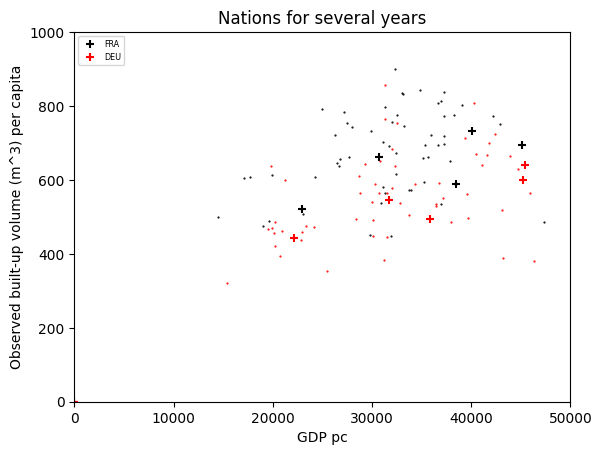

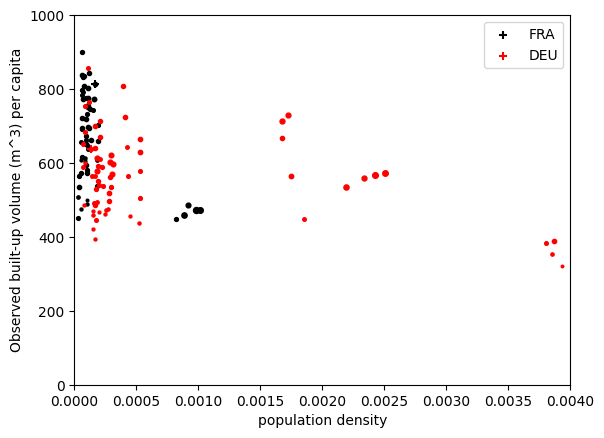

In [148]:
# # PLOT verification with gdp pc
j=-1
for region in regions:
    j = j + 1

    plt.scatter(df_gdp_cap_region_handler_log[j], df_built_up_region_handler_log[j], marker="+", color=colors_reg[j], label=region.name)
    for i in range(len(df_gdp_cap_region_handler[j])):
        plt.scatter(df_gdp_cap_region_handler[j][i], df_built_up_region_handler[j][i], color=colors_reg[j], s=.3)# s=df_pop_density_region_handler[j][i]/df_pop_density_region_handler_log[j][-1])
        
plt.title("Nations for several years")
plt.ylabel(y_label_str)
plt.xlabel("GDP pc")
plt.ylim([z_min, z_max])
plt.xlim([x_min, x_max])
# plt.xscale('log')
# plt.yscale('log')
plt.legend(loc="upper left", prop=fontP)
plt.show()

### Pop density
j = -1
for j in range(len(regions)):
    plt.scatter(df_pop_density_region_handler[j][-1], df_built_up_region_handler[j][-1], marker="+", color=colors_reg[j], label=regions[j].name)
    for i in range(len(df_gdp_cap_region_handler[j])):
        plt.scatter(df_pop_density_region_handler[j][i], df_built_up_region_handler[j][i], color=colors_reg[j], s=10*df_gdp_cap_region_handler[j][i]/df_gdp_cap_region_handler_log[j][-1])
    
# x_fit_array = np.linspace(0, 0.016)
# plt.plot(x_fit_array, exponential_decay_bias(x_fit_array, my_sat_params[0], my_sat_params[1], my_sat_params[2]))
plt.legend()
plt.xlabel("Population density")
plt.ylabel(y_label_str)
plt.xlabel("population density")
plt.ylim([z_min, z_max])
plt.xlim([y_min, y_max])
# plt.xlim(bottom=0)
# plt.xscale('log')
# plt.yscale('log')
plt.show()

### Nations by nations
# j=-1
# for region in regions:
#     j = j + 1

#     for i in range(1, len(df_gdp_cap_region_handler_log[j])):
#         plt.scatter(df_gdp_cap_region_handler_log[j][i], df_built_up_region_handler_log[j][i], color=colors_reg[j], alpha=i/len(df_gdp_cap_region_handler_log[j]))
#     # plt.plot(df_gdp_cap_region_handler_log[j][1:], np.add(np.multiply(a,df_gdp_cap_region_handler_log[j][1:]),b), color="r")
    
    
#     plt.title(region.name + "'s regions")
#     plt.ylabel(y_label_str)
#     plt.xlabel("GDP pc")
#     plt.legend(loc="upper left", prop=fontP)
#     plt.show()

### PLOT 1.1 : Observable per capita compared to time

In [149]:
if False:
    x_col = "year"
    
    pop_col = "pop"

    for region in regions:
        k = 0
        try:
            for subregion in region.subregions:
                
                filtered_df = subregion.output_df_merged.dropna(subset=[x_col, pop_col, y_col])
                x = filtered_df[x_col]
                pop = filtered_df[pop_col].values[0]
                y = filtered_df[y_col]
        
                try:
                    plt.scatter(x, y/pop, color=colors_reg[k % len(colors_reg)], label=subregion.name) #, alpha=(i+1)/6)
                except Exception as e:
                    print(e)
        
                k = k + 1
        
            plt.title(region.name + "'s regions in " + str(years))
            plt.ylabel(y_label_str)
            plt.xlabel("year")
            # plt.xlim([year_min, year_max])
            plt.legend(loc="upper left", prop=fontP)
            plt.show()
        except Exception as e:
            print(region.name, "\n", e)

### PLOT 1.2 : Observable per capita compared to grp_pc_usd_2015

FRA.5_1 0
FRA.6_1 0
FRA.7_1 0
FRA.10_1 0
FRA.11_1 0
FRA.13_1 0


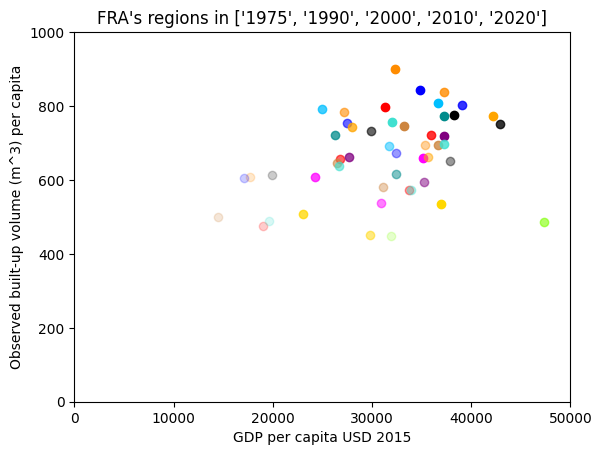

DEU.4_1 0
DEU.4_1 1
DEU.6_1 0
DEU.8_1 0
DEU.8_1 1
DEU.14_1 0
DEU.14_1 1
DEU.13_1 0
DEU.13_1 1
DEU.16_1 0
DEU.16_1 1


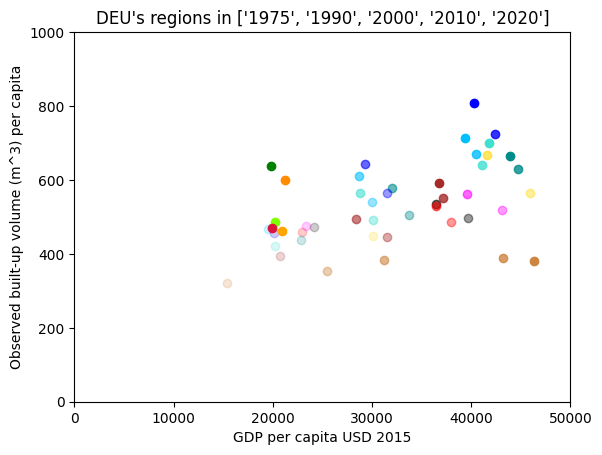

In [150]:
if True:
    x_col = "grp_pc_usd_2015"
    
    pop_col = "pop"

    for region in regions:
        k = 0
        try:
            for subregion in region.subregions:
                
                filtered_df = subregion.output_df_merged.dropna(subset=[x_col, pop_col, y_col])

                x = filtered_df[x_col]
                y = filtered_df[y_col]
                pop = filtered_df[pop_col]
        
                # plt.plot(x, y/pop, color=colors_reg[k % len(colors_reg)], label=subregion.name) #, alpha=(i+1)/6)
                for ii in range(len(pop)):
                    try:
                        plt.scatter(x[ii], y[ii]/pop[ii], color=colors_reg[k % len(colors_reg)], label=subregion.name, alpha=(ii+1)/len(x))
                    except Exception as e:
                        print(subregion.name, e)
                k = k + 1
            
            plt.title(region.name + "'s regions in " + str(years))
            plt.ylabel(y_label_str)
            plt.xlabel("GDP per capita USD 2015")
            plt.ylim([z_min, z_max])
            plt.xlim([x_min, x_max])
            # plt.legend(loc="upper right", prop=fontP)
            plt.show()
        except Exception as e:
            print("Exception", region.name, e)

### PLOT 1.3 : Observable per capita compared to observable fraction (m2 built up / all m2)

In [151]:
if False:    
    x_col = "Built up surface fraction"
    y_col = "Built up surface GHSL/Population_OECD"

    for region in regions:
        k = 0
        try:
            for subregion in region.subregions:
                
                filtered_df = subregion.output_df_merged.dropna(subset=[x_col, y_col])
                x = filtered_df[x_col]
                y = filtered_df[y_col]
        
                plt.scatter(x, y, color=colors_reg[k % len(colors_reg)], label=subregion.name) #, alpha=(i+1)/6)
        
                k = k + 1
        
            plt.title(region.name + "'s regions in " + str(years))
            plt.ylabel(y_label_str)
            plt.xlabel("Built up surface fraction")
            plt.legend(loc="upper right", prop=fontP)
            plt.show()
        except Exception as e:
            print(region.name, "\n", e)

### PLOT 1.4 : Observable per capita compared to population density

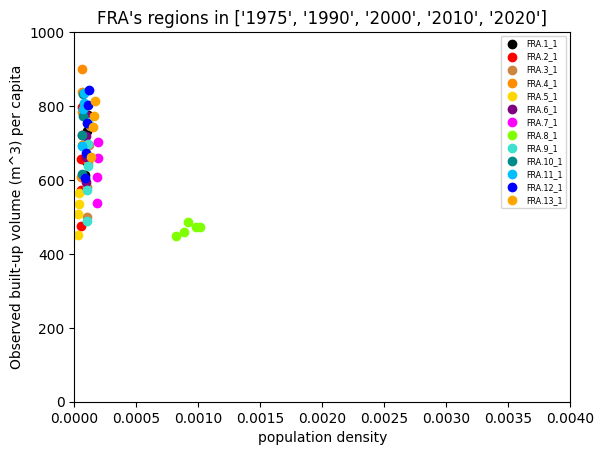

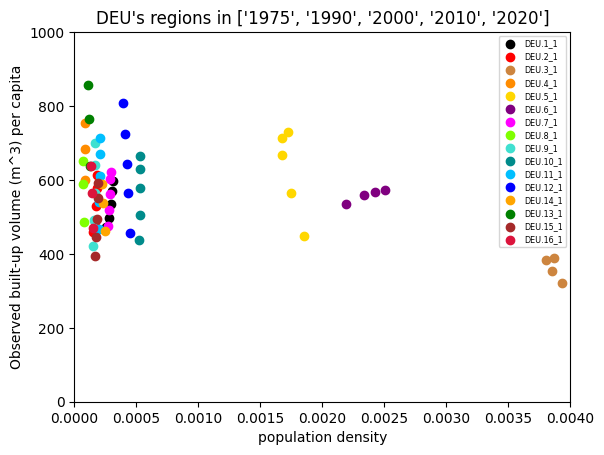

In [152]:
if True: 
    x_col = "Total surface"
    
    pop_col = "pop"

    for region in regions:
        k = 0
        try:
            for subregion in region.subregions:
                
                filtered_df = subregion.output_df_merged.dropna(subset=["year", x_col, pop_col, y_col])
                x = filtered_df[x_col]
                y = filtered_df[y_col]
                pop = filtered_df[pop_col]
        
                plt.scatter(pop/x, y/pop, color=colors_reg[k % len(colors_reg)], label=subregion.name) #, alpha=(i+1)/6)
            
                k = k + 1
        
            plt.title(region.name + "'s regions in " + str(years))
            plt.ylabel(y_label_str)
            plt.ylim([z_min, z_max])
            plt.xlim([y_min, y_max])
            plt.xlabel("population density")
            plt.legend(loc="upper right", prop=fontP)
            plt.show()
        except Exception as e:
            print(region.name, "\n", e)

## PART 4 : Fitting

The fitting part consists of several parts. We do the fits in seperate steps for two reasons. First because the fits are better if we feed it with coherent initial parameter values. Secondly because it is best for us to get a clear picture of what are fitted functions look like.

1. We fit the classical logistic part only (observable/cap vs GDP/cap) region by region to get an idea of appropriate fit parameter values.

2. We fit the exponential decay part only (observable/cap vs population density) for one year to get an idea of appropriate fit parameter values.

3. We fit the Spatio Temporal Logistic function. In order to have better results, we start the fitting algorithm with initial parameter values close to the one found in the first two step described above.

4. 

In [153]:
from Fit import Fit

### PART 4.1 : Fit the logistic only

In [154]:
# fit logistic over time, region by region
logistic_fit_handler = []

j = -1
for region in regions:
    j = j + 1
        
    logistic_fit_handler.append(Fit(region.name + "_logistic", np.array(df_gdp_cap_region_handler_log[j]), [0,0], np.array(df_built_up_region_handler_log[j])))
    logistic_fit_handler[-1].fit_logistic(init=[100, 0.00001, 15000], bounds=([0, 0, 0], [1600, 0.01, 100000]))
    print(colored(region.name, "green"))
    print(logistic_fit_handler[-1].fitted_params)
    print("R squared : ", colored( round(logistic_fit_handler[-1].r_squared,2), "red"), )
        #   "\n-----------------------------------------------------------------------")

FRA
[675.8535543673095, 0.0002807333327782946, 18580.654482105874]
R squared :  0.97
DEU
[589.1262976886586, 0.0001804407039603027, 16834.039199362305]
R squared :  0.96


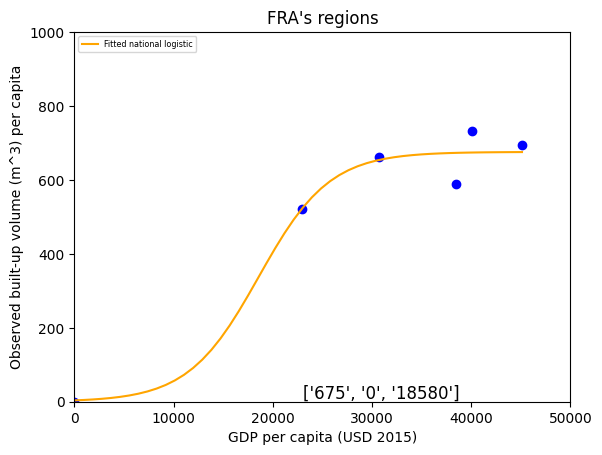

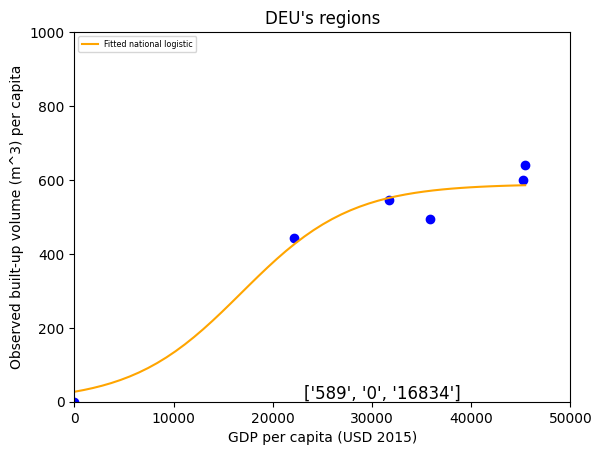

In [155]:
# # PLOT verification

j=0
for region in regions:
    x_fit_array = np.linspace(min(df_gdp_cap_region_handler_log[j]), max(df_gdp_cap_region_handler_log[j]), 50)
    fitted_params = [str(int(x)) for x in logistic_fit_handler[j].fitted_params]

    plt.plot(x_fit_array, logistic(x_fit_array, logistic_fit_handler[j].fitted_params[0], logistic_fit_handler[j].fitted_params[1], logistic_fit_handler[j].fitted_params[2]), color='orange',
             label="Fitted national logistic")
    plt.scatter(df_gdp_cap_region_handler_log[j], df_built_up_region_handler_log[j],  color='b')
    plt.text(x_fit_array[25], 10, fitted_params, fontsize=12, color='black')

    plt.title(region.name + "'s regions")
    plt.ylabel(y_label_str)
    plt.ylim([z_min, z_max])
    plt.xlim([x_min, x_max])
    plt.xlabel("GDP per capita (USD 2015)")
    plt.legend(loc="upper left", prop=fontP)
    plt.show()

    j = j + 1

#### PART 4.2 : Fit the saturation only

In [156]:
### To fit the saturation, we consider the last regional data point to fit the exponential over the most recent year

df_pop_density_region_handler_sat = []
df_built_up_region_handler_sat = []

x_col2 = "Total surface"

pop_col = "pop"

for region in regions:
    df_pop_density_region = []
    df_built_up_region = []
    
    for subregion in region.subregions:
        filtered_df = subregion.output_df_merged.dropna(subset=["year", x_col2, pop_col, y_col])
        if not filtered_df.empty:
            df_pop_density_region.append(filtered_df[pop_col].iloc[-1] / filtered_df[x_col2].iloc[-1])
            df_built_up_region.append(filtered_df[y_col].iloc[-1] / filtered_df[pop_col].iloc[-1])  
        else:
            print(colored(f"No data for subregion: {subregion.name}", "yellow"))


    if df_pop_density_region and df_built_up_region:
        df_pop_density_region_handler_sat.append(df_pop_density_region)
        df_built_up_region_handler_sat.append(df_built_up_region)
    else:
       df_pop_density_region_handler_sat.append([0, 0])
       df_built_up_region_handler_sat.append([0, 0])
       print(region.name, " is  empty and won't be fitted")

In [157]:
# # fit the saturation fct for one year
saturation_fit_handler = []

j = 0
for region in regions:
    # fit rexponential decay
    saturation_fit_handler.append(Fit(region.name + "_exponential", np.array(df_pop_density_region_handler_sat[j]), [0,0], np.array(df_built_up_region_handler_sat[j])))
    saturation_fit_handler[-1].fit_exponential_decay_bias(init=[50, 50, 20]) 

    print(colored(region.name, "green"))
    print(saturation_fit_handler[-1].fitted_params)
    print("R squared for : ", colored(round(saturation_fit_handler[-1].r_squared, 2), "red"))
    j = j + 1


FRA
[818.6579556088635, 506.72417052463527, 1.1427780686692644e-07]
R squared for :  0.49
DEU
[698.64394551376, 98.60438825279759, 2.2727651570358365e-10]
R squared for :  0.37


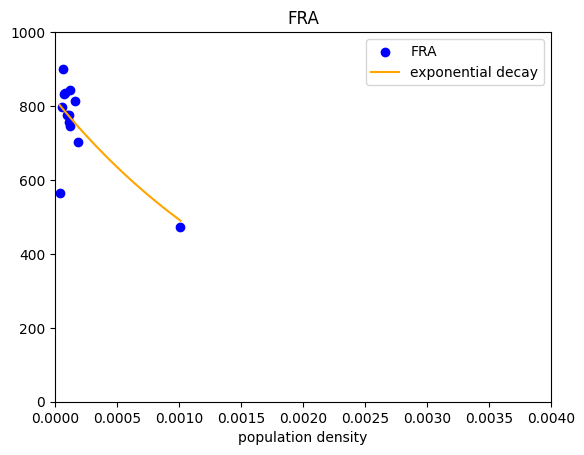

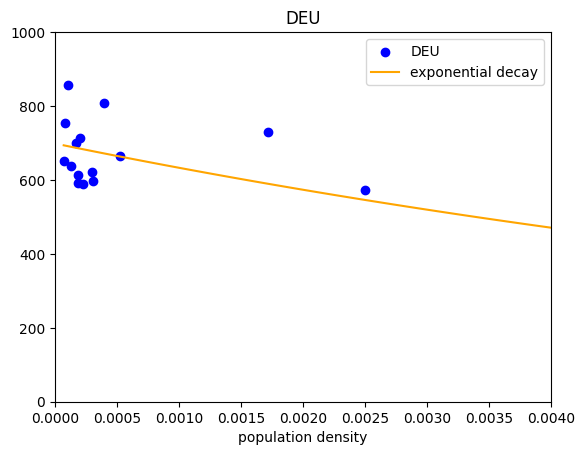

In [158]:
#  PLOT verification
j = 0
for region in regions:
    x_fit_array = np.linspace(min(df_pop_density_region_handler_sat[j]), max(df_pop_density_region_handler_sat[j]), 10)
    plt.scatter(df_pop_density_region_handler_sat[j], df_built_up_region_handler_sat[j],  color="b",
            label=region.name)
    plt.plot(saturation_fit_handler[j].x1_fit, saturation_fit_handler[j].y_fit, label="exponential decay", color="orange") 
    plt.xlabel("population density") 
    plt.ylim([z_min, z_max])
    plt.xlim([y_min, y_max])
    plt.legend(loc="upper right")
    plt.title(region.name)
    plt.show()
    j = j + 1

### PART 4.3 : Fit of the Spatio Temporal Logistic function

Now that we have an idea of the parameters and their fitness we can derive parameters for the Spatio Temporal Logistic function as a whole. For this, we concatenate all our points, all regions, all years.

In [159]:
# Fit STL logistic with density
# This is the automatic fit
STL_fit_handler = []

for i in range(len(regions)):
    try:
        STL_fit_handler.append(Fit("tmp", np.array(df_gdp_cap_region_handler[i]), np.array(df_pop_density_region_handler[i]), np.array(df_built_up_region_handler[i])))
        STL_fit_handler[-1].fit_STL(init=[10, 30, 10, 0.00001, 6000], bounds=([0, 0, 0, 0, 0], [1600, 100, 100000, 10, 50000]))
    
        print(colored(regions[i].name, "green"))
        print(STL_fit_handler[-1].fitted_params)
        print("R squared : ", colored(round(STL_fit_handler[-1].r_squared, 2), "red"))
    except Exception as e:
        print(regions[i].name, "\n", e)

FRA
[703.6457256954733, 99.99999999998816, 1.8972979748558244e-08, 0.00019517905443197718, 10701.436061726068]
R squared :  0.23
DEU
[687.2828461651864, 92.01598673900352, 0.04404156566579906, 8.751033336300926e-05, 9934.043629463577]
R squared :  0.43


Now that we have the fitted params for the spatio temporal logistic, we can compare them with the ones we found indepently for the logsitic and the exponential fits.

In [160]:
for i in range(len(regions)):
    try:    
        print(colored(regions[i].name, "green"))
        print(STL_fit_handler[i].fitted_params, colored(round(STL_fit_handler[i].r_squared, 2), "red"))
        print([saturation_fit_handler[i].fitted_params[0],saturation_fit_handler[i].fitted_params[1],saturation_fit_handler[i].fitted_params[2],logistic_fit_handler[i].fitted_params[1],logistic_fit_handler[i].fitted_params[2],], colored((round(logistic_fit_handler[i].r_squared, 2), round(saturation_fit_handler[i].r_squared, 2)), "red"))
    except Exception as e:
        print(regions[i].name, "\n", e)

FRA
[703.6457256954733, 99.99999999998816, 1.8972979748558244e-08, 0.00019517905443197718, 10701.436061726068] 0.23
[818.6579556088635, 506.72417052463527, 1.1427780686692644e-07, 0.0002807333327782946, 18580.654482105874] (0.97, 0.49)
DEU
[687.2828461651864, 92.01598673900352, 0.04404156566579906, 8.751033336300926e-05, 9934.043629463577] 0.43
[698.64394551376, 98.60438825279759, 2.2727651570358365e-10, 0.0001804407039603027, 16834.039199362305] (0.96, 0.37)


At this step, we successfully fitted the function STL to all our available data. But, as we may want to use different values for the rest of our study, it is good to save the values of the study. For example, if I want to see if the values found on FRA are consistent with data from DEU, I may continue with the fitted parameters of FRA even though my current study is on DEU.

## PART 5 : the STL function fit


In [161]:
aa = 700
bb = 100
cc = 0
dd = 0.001
ee = 20000

my_own_fit = [aa, bb, cc, dd, ee]

# Fit_type is the type of fit we want to use for the final comparisons.
# If 0 : we consider the fitted parameters of the STL function
# If 1 : we consider the fitted parameters of the logistic part and of the saturation part together
# If 2 : we consider my_own_fit
fit_type = 2

# If fit_type == 0 or 1, best_region_fit will be the country's equation to use on all the other countries  
best_region_fit = 0


### PART 5.1 : 3D Plot with one equation for one country

The surface is the fitted Spatio Temporal logistic function.
The points are the data

In [162]:
three_D_plots = True

In [163]:
if False:
    if three_D_plots:
        import plotly.graph_objects as go

        for j in range(len(regions)):
            try:            
                # Create the surface plot using Plotly
                fig = go.Figure(data=[
                    go.Scatter3d(
                        x=df_gdp_cap_region_handler[j], y=df_pop_density_region_handler[j], z=df_built_up_region_handler[j],
                        mode='markers',  # Use 'markers' for scatter plot
                        marker=dict(
                            size=6,  # Size of the points
                            color=df_built_up_region_handler[j],  # Color of the points
                            colorscale='Turbo',  # Colorscale for the points
                            # cmin=cmin,
                            # cmax=cmax,
                            opacity=1.0
                        )
                    ),
                    
                    ]
                    )
            
                # Customize the layout
                fig.update_layout(title=f'3D STL\'s function {regions[j].name}',
                                scene=dict(
                                    xaxis=dict(title='grp_pc_usd_2015', range=[x_min, x_max]),
                                    yaxis=dict(title='population density', range=[y_min, y_max]),
                                    zaxis=dict(title=y_col, range=[z_min, z_max]),
                                ),
                                width=800, height=700)
            
                # Show the plot
                fig.show()
                
            except Exception as e:
                print(region.name, "\n", e)
    


In [164]:
### last
if three_D_plots:
    import plotly.graph_objects as go

    try:
        # Create an empty figure
        fig = go.Figure()

        # Create a meshgrid of x and y values
        x = np.linspace(x_min, x_max, 50)
        y = np.linspace(y_min, y_max, 50)
        x_grid, y_grid = np.meshgrid(x, y)
        z = STL([x_grid, y_grid], my_own_fit[0],my_own_fit[1],my_own_fit[2],my_own_fit[3],my_own_fit[4],)
        cmin = np.min(z)
        cmax = np.max(z)

        fig.add_trace(
            go.Surface(
                    z=z, 
                    x=x_grid, 
                    y=y_grid, 
                    colorscale="Turbo", 
                    cmin=cmin,
                    cmax=cmax,
                    opacity=0.4),
        )

        for j in range(len(regions)):
            # Add a scatter trace for each region
            fig.add_trace(
                go.Scatter3d(
                    x=df_gdp_cap_region_handler[j],
                    y=df_pop_density_region_handler[j],
                    z=df_built_up_region_handler[j],
                    mode='markers',  # Use 'markers' for scatter plot
                    marker=dict(
                        size=6,  # Size of the points
                        color=df_built_up_region_handler[j],  # Color of the points
                        colorscale='Turbo',  # Colorscale for the points
                        opacity=1.0
                    ),
                    name=regions[j].name  # Add region name as trace legend
                )
            )
        
        # Customize the layout
        fig.update_layout(
            title='3D STL\'s function for all regions',
            scene=dict(
                xaxis=dict(
                    title='grp_pc_usd_2015',
                    range=[x_min, x_max],
                    # type='log'  # Set x-axis to log scale
                ),
                yaxis=dict(
                    title='population density',
                    range=[y_min, y_max],
                    # type='log'  # Set y-axis to log scale
                ),
                zaxis=dict(
                    title=y_col,
                    range=[z_min, z_max],
                    # type='log'  # Set z-axis to log scale
                )
            ),
            width=800,
            height=700
        )
        
        # Show the plot
        fig.show()

    except Exception as e:
        print("Error:", e)


In [165]:
if three_D_plots:
    import plotly.graph_objects as go

    for j in range(len(regions)):
        try:
            # Create a meshgrid of x and y values
            x = np.linspace(x_min, x_max, 50)
            y = np.linspace(y_min, y_max, 50)
            x_grid, y_grid = np.meshgrid(x, y)

            if fit_type == 0:
                z = STL([x_grid, y_grid], STL_fit_handler[j].fitted_params[0], STL_fit_handler[j].fitted_params[1], STL_fit_handler[j].fitted_params[2], STL_fit_handler[j].fitted_params[3], STL_fit_handler[j].fitted_params[4])
            elif fit_type == 1: 
                z = STL([x_grid, y_grid], saturation_fit_handler[j].fitted_params[0], saturation_fit_handler[j].fitted_params[1], STL_fit_handler[j].fitted_params[2], logistic_fit_handler[j].fitted_params[1], logistic_fit_handler[j].fitted_params[2])
            elif fit_type == 2:
                z = STL([x_grid, y_grid], my_own_fit[0], my_own_fit[1], my_own_fit[2], my_own_fit[3], my_own_fit[4])

            cmin = np.min(z)
            cmax = np.max(z)
            
            # Create the surface plot using Plotly
            fig = go.Figure(data=[
                go.Surface(
                    z=z, 
                    x=x_grid, 
                    y=y_grid, 
                    colorscale="Turbo", 
                    cmin=cmin,
                    cmax=cmax,
                    opacity=0.4),
                go.Scatter3d(
                    x=df_gdp_cap_region_handler[j], y=df_pop_density_region_handler[j], z=df_built_up_region_handler[j],
                    mode='markers',  # Use 'markers' for scatter plot
                    marker=dict(
                        size=6,  # Size of the points
                        color=df_built_up_region_handler[j],  # Color of the points
                        colorscale='Turbo',  # Colorscale for the points
                        cmin=cmin,
                        cmax=cmax,
                        opacity=1.0
                    )
                ),
                
                ]
                )
        
            # Customize the layout
            fig.update_layout(title=f'3D STL\'s function {regions[j].name}',
                            scene=dict(
                                xaxis=dict(title='grp_pc_usd_2015',range=[x_min, x_max]),
                                yaxis=dict(title='population density', range=[y_min, y_max]),
                                zaxis=dict(title=y_col, range=[z_min, z_max],),
                            ),
                            width=800, height=700)
        
            # Show the plot
            fig.show()
        except Exception as e:
            print(region.name, "\n", e)

### PART 5.2 : 3D Plot with only one equation for every country

Now we want to compare all the countries to only one fit.

In [166]:
if three_D_plots:    
    if fit_type == 0:
        global_STL_fit_params = STL_fit_handler[best_region_fit].fitted_params
    elif fit_type == 1: 
        global_STL_fit_params = [saturation_fit_handler[best_region_fit].fitted_params[0], saturation_fit_handler[best_region_fit].fitted_params[1], saturation_fit_handler[best_region_fit].fitted_params[2], logistic_fit_handler[best_region_fit].fitted_params[1], logistic_fit_handler[best_region_fit].fitted_params[2]]
    elif fit_type == 2:
        global_STL_fit_params = my_own_fit      

    # Create a meshgrid of x and y values
    x = np.linspace(x_min, x_max, 50)
    y = np.linspace(y_min, y_max, 50)
    x_grid, y_grid = np.meshgrid(x, y)

    z = STL([x_grid,y_grid], global_STL_fit_params[0], global_STL_fit_params[1], global_STL_fit_params[2], global_STL_fit_params[3], global_STL_fit_params[4])    

    cmin = np.min(z)
    cmax = np.max(z)

    for j in range(len(regions)):
        try:            
            # Create the surface plot using Plotly
            fig = go.Figure(data=[
                go.Surface(
                    z=z, 
                    x=x_grid, 
                    y=y_grid, 
                    colorscale="Turbo", 
                    cmin=cmin,
                    cmax=cmax,
                    opacity=0.4),
                go.Scatter3d(
                    x=df_gdp_cap_region_handler[j], y=df_pop_density_region_handler[j], z=df_built_up_region_handler[j],
                    mode='markers',  # Use 'markers' for scatter plot
                    marker=dict(
                        size=6,  # Size of the points
                        color=df_built_up_region_handler[j],  # Color of the points
                        colorscale='Turbo',  # Colorscale for the points
                        cmin=cmin,
                        cmax=cmax,
                        opacity=1.0
                    )
                ),
                
                ]
                )
        
            # Customize the layout
            fig.update_layout(title=regions[j].name + "'s regions fitted with " + regions[best_region_fit].name + "'s equation",
                            scene=dict(
                                xaxis=dict(title='grp_pc_usd_2015', range=[x_min, x_max]),
                                yaxis=dict(title='population density', range=[y_min, y_max]),
                                zaxis=dict(title=y_col, range=[z_min, z_max]),
                            ),
                            width=800, height=700)
        
            # Show the plot
            fig.show()
        except Exception as e:
            print(region.name, "\n", e)

## PART 6 : Predicted vs Observed Plot

To have a better view on the quality of the 3D logistic curve, we plot the predicted value vs the observed value.  
We do this in two steps :

1. The next cell shows the prediction fitted on each individual country. This should result in the best fits.
2. The following cell shows the the prediction with the logistic curve of one predefined country, applied to all the others. This is to see if one equation is sufficient to fit reasonnably all the countries worldwide.

### PART 6.1

In [167]:
# Statistics with the respective equations for each region

for j in range(len(regions)):
    if fit_type == 0:
        global_STL_fit_params = STL_fit_handler[j].fitted_params
    elif fit_type == 1: 
        global_STL_fit_params = [saturation_fit_handler[j].fitted_params[0], saturation_fit_handler[j].fitted_params[1], saturation_fit_handler[j].fitted_params[2], logistic_fit_handler[j].fitted_params[1], logistic_fit_handler[j].fitted_params[2]]
    elif fit_type == 2:
        global_STL_fit_params = my_own_fit   

    obs = df_built_up_region_handler[j]
    pred = STL([np.array(df_gdp_cap_region_handler[j]), np.array(df_pop_density_region_handler[j])], global_STL_fit_params[0], global_STL_fit_params[1], global_STL_fit_params[2], global_STL_fit_params[3], global_STL_fit_params[4])

    print(colored(regions[j].name, "green"))
    print("RMSE: ", round(RMSE(obs, pred), 2))
    print("MAPE: ", round(MAPE(obs, pred), 2))
    print("STDR: ", round(STDR(obs, pred), 2))
    print("BIAS: ", round(BIAS(obs, pred), 2))
    print("R²  : ", round(R_SQ(obs, pred), 2))
    print("PEAR: ", round(PEARSON(obs, pred)[0], 2), " p_value: ", round(PEARSON(obs, pred)[1], 2))

FRA
RMSE:  169.29
MAPE:  20.4
STDR:  165.94
BIAS:  33.51
R²  :  -1.02
PEAR:  0.37  p_value:  0.0
DEU
RMSE:  127.29
MAPE:  20.79
STDR:  119.64
BIAS:  -43.46
R²  :  -0.35
PEAR:  0.52  p_value:  0.0


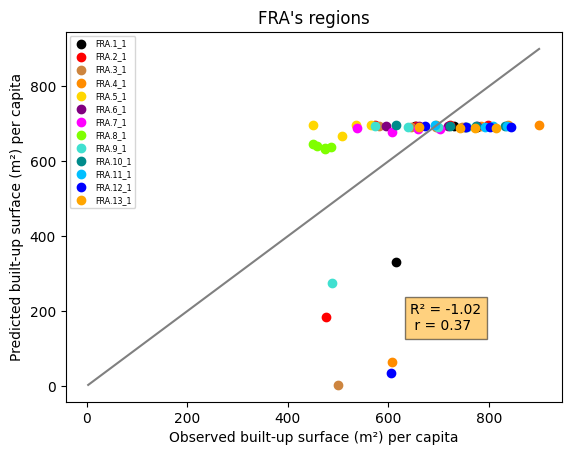

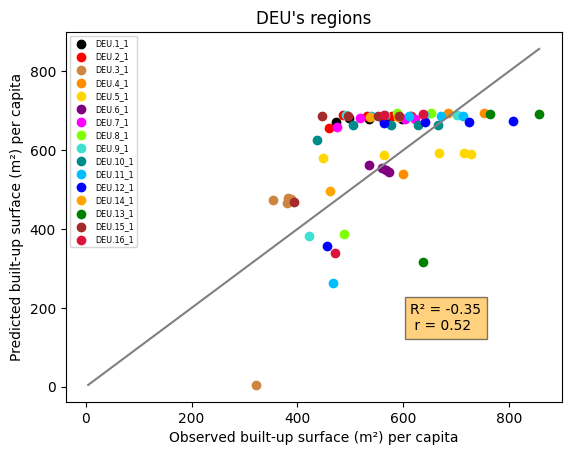

In [168]:
# here we plot the predicted values against the observations with the prediction fitted on the country. Every country has its own fit.

x1_col = "grp_pc_usd_2015"
x2_col = "Total surface"

pop_col = "pop"

reg_idx = -1
for region in regions:
    reg_idx += 1
    
    if fit_type == 0:
        global_STL_fit_params = STL_fit_handler[reg_idx].fitted_params
    elif fit_type == 1: 
        global_STL_fit_params = [saturation_fit_handler[reg_idx].fitted_params[0], saturation_fit_handler[reg_idx].fitted_params[1], saturation_fit_handler[reg_idx].fitted_params[2], logistic_fit_handler[reg_idx].fitted_params[1], logistic_fit_handler[reg_idx].fitted_params[2]]
    elif fit_type == 2:
        global_STL_fit_params = my_own_fit   
    
    k = 0
    min_point = 999
    max_point = 0
    obs_region = []
    pred_region = []
    try:
        for subregion in region.subregions:
            
            filtered_df = subregion.output_df_merged.dropna(subset=[x1_col, x2_col, pop_col, y_col])
            x1 = filtered_df[x1_col]
            x2 = filtered_df[x2_col]
            y = filtered_df[y_col]
            pop =  filtered_df[pop_col]

            obs = y/pop
            pred = STL([x1,pop/x2], global_STL_fit_params[0], global_STL_fit_params[1], global_STL_fit_params[2], global_STL_fit_params[3], global_STL_fit_params[4]) 
            obs_region += obs.to_list()  
            pred_region += pred.to_list()
            plt.scatter(obs, pred, color=colors_reg[k % len(colors_reg)], label=subregion.name) #, alpha=(i+1)/6)

            try:
                min_point = min(min(min(obs), min(pred)), min_point)
                max_point = max(max(max(obs), max(pred)), max_point)
            except:
                pass
            
            k = k + 1
        
        
        x_plot_array = np.linspace(min_point, max_point, 50)
        plt.title(region.name + "'s regions")
        plt.plot(x_plot_array, x_plot_array, color='grey',)
        plt.text(x_plot_array[35], x_plot_array[8], "R² = "+str(round(R_SQ(np.array(obs_region), np.array(pred_region)),2))+"\n r = "+str(round(PEARSON(np.array(obs_region), np.array(pred_region))[0],2)), bbox=dict(facecolor="orange", alpha=0.5, edgecolor="black"))
        plt.ylabel("Predicted built-up surface (m²) per capita")
        plt.xlabel("Observed built-up surface (m²) per capita")
        plt.legend(loc="upper left", prop=fontP)
        plt.show()
    except Exception as e:
        print(region.name, "\n", e)

### PART 6.2 : with only one equation for every country

In [169]:
# Statistics with one equation for every region

if fit_type == 0:
    global_STL_fit_params = STL_fit_handler[best_region_fit].fitted_params
elif fit_type == 1: 
    global_STL_fit_params = [saturation_fit_handler[best_region_fit].fitted_params[0], saturation_fit_handler[best_region_fit].fitted_params[1], saturation_fit_handler[best_region_fit].fitted_params[2], logistic_fit_handler[best_region_fit].fitted_params[1], logistic_fit_handler[best_region_fit].fitted_params[2]]
elif fit_type == 2:
    global_STL_fit_params = my_own_fit   

for j in range(len(regions)):
    obs = df_built_up_region_handler[j]
    pred = STL([np.array(df_gdp_cap_region_handler[j]), np.array(df_pop_density_region_handler[j])], global_STL_fit_params[0], global_STL_fit_params[1], global_STL_fit_params[2], global_STL_fit_params[3], global_STL_fit_params[4])

    print(colored(regions[j].name+" with "+regions[best_region_fit].name+"'s fit.", "green"))
    print("RMSE: ", round(RMSE(obs, pred), 2))
    print("MAPE: ", round(MAPE(obs, pred), 2))
    print("STDR: ", round(STDR(obs, pred), 2))
    print("BIAS: ", round(BIAS(obs, pred), 2))
    print("R²  : ", round(R_SQ(obs, pred), 2))
    print("PEAR: ", round(PEARSON(obs, pred)[0], 2), " p_value: ", round(PEARSON(obs, pred)[1], 2))

FRA with FRA's fit.
RMSE:  169.29
MAPE:  20.4
STDR:  165.94
BIAS:  33.51
R²  :  -1.02
PEAR:  0.37  p_value:  0.0
DEU with FRA's fit.
RMSE:  127.29
MAPE:  20.79
STDR:  119.64
BIAS:  -43.46
R²  :  -0.35
PEAR:  0.52  p_value:  0.0


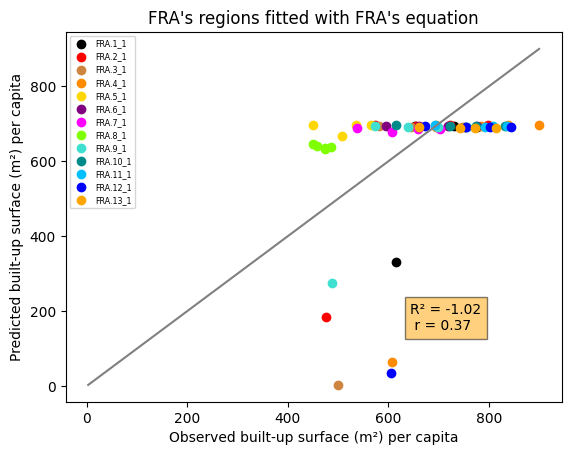

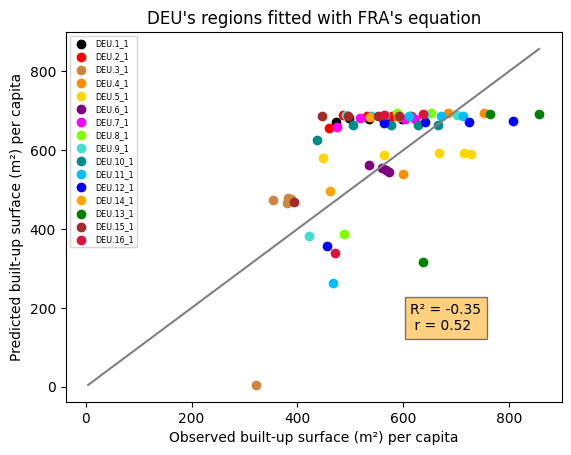

In [170]:
# here we compare all the predicted values with only one logistic curve. 

if fit_type == 0:
    global_STL_fit_params = STL_fit_handler[best_region_fit].fitted_params
elif fit_type == 1: 
    global_STL_fit_params = [saturation_fit_handler[best_region_fit].fitted_params[0], saturation_fit_handler[best_region_fit].fitted_params[1], saturation_fit_handler[best_region_fit].fitted_params[2], logistic_fit_handler[best_region_fit].fitted_params[1], logistic_fit_handler[best_region_fit].fitted_params[2]]
elif fit_type == 2:
    global_STL_fit_params = my_own_fit  
     
x1_col = "grp_pc_usd_2015"
x2_col = "Total surface"

pop_col = "pop"

for region in regions:
    k = 0
    min_point = 999
    max_point = 0
    obs_region = []
    pred_region = []
    try:
        for subregion in region.subregions:
            
            filtered_df = subregion.output_df_merged.dropna(subset=[x1_col, x2_col, pop_col, y_col])
            x1 = filtered_df[x1_col]
            x2 = filtered_df[x2_col]
            y = filtered_df[y_col]
            pop = filtered_df[pop_col]

            obs = y/pop
            pred = STL([x1, pop/x2], global_STL_fit_params[0], global_STL_fit_params[1], global_STL_fit_params[2], global_STL_fit_params[3], global_STL_fit_params[4])
            obs_region += obs.to_list()  
            pred_region += pred.to_list()
            
            plt.scatter(obs, pred, color=colors_reg[k % len(colors_reg)], label=subregion.name) #, alpha=(i+1)/6)

            try:
                min_point = min(min(min(obs), min(pred)), min_point)
                max_point = max(max(max(obs), max(pred)), max_point)
            except:
                pass
            
            k = k + 1
        
        x_plot_array = np.linspace(min_point, max_point, 50)
        plt.title(region.name + "'s regions fitted with " + regions[best_region_fit].name + "'s equation")
        plt.plot(x_plot_array, x_plot_array, color='grey',)
        plt.text(x_plot_array[35], x_plot_array[8], "R² = "+str(round(R_SQ(np.array(obs_region), np.array(pred_region)),2))+"\n r = "+str(round(PEARSON(np.array(obs_region), np.array(pred_region))[0],2)), bbox=dict(facecolor="orange", alpha=0.5, edgecolor="black"))
        plt.ylabel("Predicted built-up surface (m²) per capita")
        plt.xlabel("Observed built-up surface (m²) per capita")
        plt.legend(loc="upper left", prop=fontP)
        plt.show()
    except Exception as e:
        print(region.name, "\n", e)

### PART 6.3 Plot all on the same figure

In [171]:
# WORK IN PROGRESS

## PART 7 : 2nd Method

Optimization terminated successfully    (Exit mode 0)
            Current function value: 15.408527691355554
            Iterations: 25
            Function evaluations: 886
            Gradient evaluations: 21
Optimal solution: [7.32575954e+02 4.81368217e-04 1.81089101e+04 6.75780139e+02
 1.64698665e-04 1.69061037e+04 6.80731091e+02 1.73785400e-04
 1.92799340e+04 7.24884762e+02 5.06631811e-04 1.81003961e+04
 6.94160897e+02 1.87935630e-04 1.81490952e+04 7.04119746e+02
 1.88683227e-04 1.79597124e+04 7.03169124e+02 2.17343457e-04
 1.80889229e+04 5.38315537e+02 6.05329541e-04 1.81488877e+04
 6.80138632e+02 1.66803633e-04 1.92823930e+04 7.13386902e+02
 4.49736757e-04 1.81490937e+04 7.14855682e+02 4.56861396e-04
 1.81490947e+04 6.93121538e+02 4.81782800e-04 1.78246922e+04
 7.00951067e+02 4.82837100e-04 1.81490952e+04]
Objective function value: 15.408527691355554


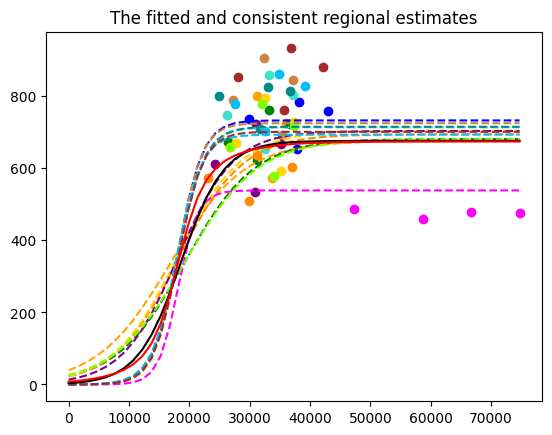

In [178]:
from RegionalFit import RegionalFit

j = 0
year_list = [1990, 2000, 2010, 2020]
# year_list = [2000, 2020]
# year_list = [2010]

pop_distrib = []
pop_total = 0
data_x = []
data_y = []

for subregion in regions[j].subregions:
    x_ = []
    y_ = []
    for year_ in year_list:
        try:
            pop = int(subregion.output_df_merged.loc[subregion.output_df_merged["year"]==year_, "Population"].values[0])
            x = int(subregion.output_df_merged.loc[subregion.output_df_merged["year"]==year_, "grp_pc_usd_2015"].values[0])
            y = int(subregion.output_df_merged.loc[subregion.output_df_merged["year"]==year_, "Built up volume GHSL"].values[0])/pop

            x_.append(x)
            y_.append(y)

            if year_ == year_list[-1]:
                pop_distrib.append(int(pop))
                pop_total += pop

        except Exception as e:
            subregion.name
            subregion.output_df_merged.head()
            print(e)
    
    data_x.append(x_)
    data_y.append(y_)

pop_distrib = np.array(pop_distrib) / pop_total
data_x = np.array(data_x)
data_y = np.array(data_y)

national_x = np.linspace(0, max(df_gdp_cap_region_handler[j]))
national_y = logistic(national_x, logistic_fit_handler[j].fitted_params[0], logistic_fit_handler[j].fitted_params[1], logistic_fit_handler[j].fitted_params[2])


regional_fit = RegionalFit(regions[j].name, national_x, national_y)
regional_fit.pop_distrib = pop_distrib
regional_fit.data_x = data_x
regional_fit.data_y = data_y

### If it is not None, a tolerance is considered during the fit. It is necessary if there are more than one year as data_x or y
regional_fit.tolerance_percentage = 30
regional_fit.initial_guess = [logistic_fit_handler[j].fitted_params[0], logistic_fit_handler[j].fitted_params[1], logistic_fit_handler[j].fitted_params[2]]
regional_fit.bounds = [(logistic_fit_handler[j].fitted_params[0]/2, 2*logistic_fit_handler[j].fitted_params[0]), (0.5*logistic_fit_handler[j].fitted_params[1], 2*logistic_fit_handler[j].fitted_params[1]),
                        (0.5*logistic_fit_handler[j].fitted_params[2], 2*logistic_fit_handler[j].fitted_params[2])]

# regional_fit.bounds = [(400, 1000), (0.0001, 0.001), (10000, 30000)]

regional_fit.optimize()
regional_fit.plot()

The End.